# Inferencing Coarse Tuning Model

In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer

from PIL import Image
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import matplotlib.cm as cm
from matplotlib.pyplot import subplots

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib

import yaml

zsh:1: command not found: nvcc
torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6


In [2]:
#!scp apaurevi@graham.computecanada.ca:projects/def-baugh/apaurevi/QuantumDotControl/output/model_final.pth ./output/model_sept_12_charge_state.pth

In [3]:
# Load trained model path
model_path = os.path.join("../output", "model_july_29.pth")  # path to the model we just trained
model_name = 'dot_num'

In [4]:
config_path = "./config.yaml"

processor = 'cpu'

with open(config_path, 'r') as config_yaml:
            model_yaml = yaml.load(config_yaml, Loader=yaml.FullLoader)
            model_config = model_yaml[model_name]
            model_info = model_config['info']
            model_hyperparams = model_config['hyperparameters']

            model_device = model_yaml['device']

ROOT_DIR = "../../../autotuning/data/csd"

MODEL_DATA_DIR = os.path.join(ROOT_DIR, "processed")

MODEL_TRAIN_DATA_DIR = os.path.join(MODEL_DATA_DIR,"train")
MODEL_VAL_DATA_DIR = os.path.join(MODEL_DATA_DIR,"val")
MODEL_TEST_DATA_DIR = os.path.join(MODEL_DATA_DIR,"test")

In [146]:
from detectron2.engine import DefaultTrainer

print(model_hyperparams)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("csd_train",)
cfg.DATASETS.TEST = ()

cfg.MODEL.DEVICE = processor 
cfg.DATALOADER.NUM_WORKERS = model_device[processor]['num_workers']

cfg.SOLVER.IMS_PER_BATCH = model_hyperparams['batch_num']
cfg.SOLVER.BASE_LR = model_hyperparams['learning_rate']
cfg.SOLVER.MAX_ITER = model_hyperparams['num_epochs']
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = model_hyperparams['batch_size_per_img']
cfg.MODEL.ROI_HEADS.NUM_CLASSES = model_info['num_of_classes'] 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set a custom testing threshold
predictor = DefaultPredictor(cfg)


{'learning_rate': 0.0002, 'augments_per_sim_img': 2, 'augments_per_exp_img': 50, 'num_epochs': 7000, 'batch_num': 10, 'dataset_size': 1001, 'train_val_split': 0.8, 'batch_size_per_img': 128}
[03/14 11:25:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../output/model_july_29.pth ...


In [147]:
def get_csd_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        record["file_name"] = os.path.join(img_dir, v["filename"])
        record["image_id"] = idx

        annos = v["regions"]

        objs = []

        if type(annos) == list: # custom JSONs are in list format need to make them the same
             annos = dict(enumerate(annos))

        for _, anno in annos.items():

            regions = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]

            # if len(px) <= 10 or len(py) <= 10:
            #         # print("Ignoring polygon from ", v["filename"], "because a polygon was too small for detectron2.")
            #         continue
            
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            try: 
                category_dict = {"ND": 0, "LD": 1, "CD": 2, "RD": 3, "DD": 4}
                category_id = category_dict[regions["label"]]

            except KeyError:
                # diff model
                category_dict = {0: 0, 5: 1, 10: 2, 3: 3, 8: 4, 13: 5, 6:6, 11:7, 16:8} # converts the unique charge state number to an ID.
                class_dict = {"(0,0)": 0, "(0,1)": 5, "(0,2)": 10, "(1,0)": 3, "(1,1)": 8, "(1,2)": 13, "(2,0)": 6, "(2,1)": 11, "(2,2)": 16}
                try: 
                    category_id = category_dict[regions["label"]]
                except KeyError:
                    category_id = category_dict[class_dict[regions['label']]]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
            }

            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

## Validation

../../../autotuning/data/csd/processed/val/20171118-131354839943_augment3.jpg


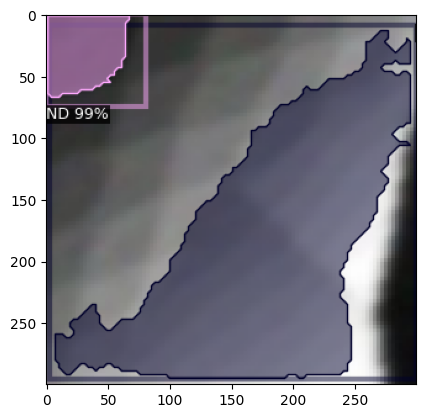

IndexError: list index out of range

In [148]:
DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val"]:
    DatasetCatalog.register("csd_" + d, lambda d=d: get_csd_dicts(os.path.join(MODEL_DATA_DIR,d)))
    MetadataCatalog.get("csd_" + d).set(thing_classes=list(model_info['class_dict'].keys()))

csd_train_metadata = MetadataCatalog.get("csd_train")
csd_val_metadata = MetadataCatalog.get("csd_val")

def check_image_exists(directory, image_name):
    # Get the list of files in the directory
    files = os.listdir(directory)

    # Check if the image_name exists with any image extension
    for file in files:
        if file == image_name:
            print(file, image_name)
            return True

    return False

dataset_dicts = get_csd_dicts(MODEL_VAL_DATA_DIR)
for d in random.sample(dataset_dicts, 1):    

    im = cv2.imread(d['file_name'])

    

    print(d['file_name'])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    v = Visualizer(im[:, :, ::-1],
                   metadata=csd_val_metadata, 
                   scale=3,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()
    
    plt.cla()
    plt.clf()
    plt.close()
    visualizer = Visualizer(im[:, :, ::-1], metadata=csd_val_metadata, scale=3)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1],cmap=cm.summer)
    plt.show()

## Experimental Test

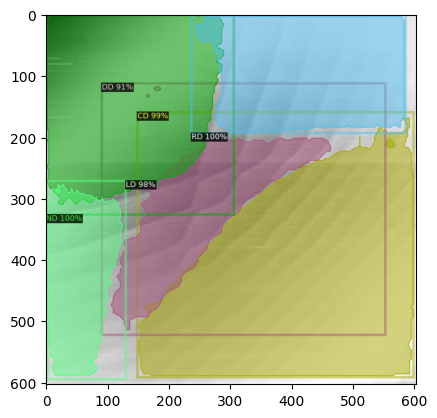

In [149]:
test_image = os.path.join(MODEL_TEST_DATA_DIR, "exp_large_09.jpg")
im = cv2.imread(test_image)
im = cv2.rotate(im, cv2.ROTATE_180)
im_blur = cv2.bilateralFilter(im, 3,50,50)
gray = cv2.cvtColor(im_blur, cv2.COLOR_BGR2GRAY)
# Define the sharpening kernel (Laplacian)
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])


# # Apply the kernel to the image using filter2D
# sharpened_image = cv2.filter2D(gray, -1, kernel)

# plt.imshow(sharpened_image)
# plt.colorbar()
# plt.show()

# # sobelxy = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3) # Combined X and Y Sobel Edge Detection
# # plt.imshow(cv2.rotate(sobelxy.astype('uint8'), cv2.ROTATE_180))
# # plt.colorbar()
# # plt.show()


# # im_adap_thres = cv2.adaptiveThreshold(sobelxy.astype('uint8'),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
# #  cv2.THRESH_BINARY_INV,21,25)

# # # plt.imshow(im_thres)
# # # plt.colorbar()
# # # plt.show()
# # # im = cv2.cvtColor(im_thres, cv2.COLOR_GRAY2RGB)
# # # plt.imshow(im)
# # # plt.colorbar()
# # # plt.show()
# # im = cv2.rotate(im_adap_thres, cv2.ROTATE_180)
# # plt.imshow(im)
# # plt.colorbar()
# # plt.show()
# # im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)

# # im = cv2.rotate(sobelxy.astype('uint8'), cv2.ROTATE_180)
# im = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
# im = cv2.rotate(im, cv2.ROTATE_180)
# plt.imshow(im)
# plt.colorbar()
# plt.show()
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
csd_test_metadata = MetadataCatalog.get("csd_val")
v = Visualizer(im[:, :, ::-1],
                metadata=csd_test_metadata, 
                scale=3,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())

plt.show()

In [150]:
import pandas as pd
data = '../../bootstrapping/data/Data_SHTs_Triton/20240131/163528/data.dat'
df = pd.read_table(data, sep='\s+')

In [151]:
# Get X1 and X2 of the graph
X1 = np.unique(np.array(df['RB']))
minX1, maxX1 = np.min(X1), np.max(X1)
X2 = np.unique(np.array(df['LB']))
minX2, maxX2 = np.min(X2), np.max(X2)
X1 = X1[~np.isnan(X1)]
X2 = X2[~np.isnan(X2)]

print(len(X1))
print(len(X2))

Y = np.array(df['Idc'])
Y = np.concatenate((Y,np.zeros(0)))

Y = Y[~np.isnan(Y)].reshape(len(X1), len(X2))

200
160


(200, 160)


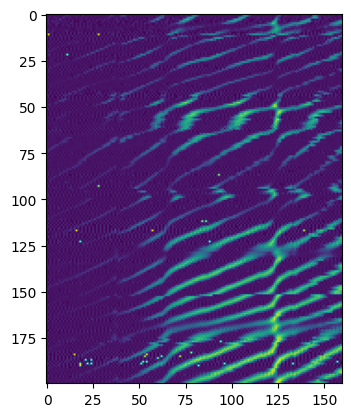

In [152]:
# info = np.iinfo(Y.dtype) # Get the information of the incoming image type
# print(info.max)
Y = Y / Y.max() # normalize the data to 0 - 1
data = 255 * Y # Now scale by 255
im = data.astype(np.uint8)
print(im.shape)
# im = im[40:,90:130]
plt.imshow(im)
plt.show()

In [153]:
img = np.stack((im,im,im),axis=2)

In [154]:
print(img.shape)
print(img)

(200, 160, 3)
[[[12 12 12]
  [19 19 19]
  [ 9  9  9]
  ...
  [13 13 13]
  [12 12 12]
  [12 12 12]]

 [[13 13 13]
  [12 12 12]
  [12 12 12]
  ...
  [ 9  9  9]
  [18 18 18]
  [10 10 10]]

 [[18 18 18]
  [12 12 12]
  [21 21 21]
  ...
  [ 8  8  8]
  [13 13 13]
  [ 8  8  8]]

 ...

 [[14 14 14]
  [ 9  9  9]
  [14 14 14]
  ...
  [18 18 18]
  [11 11 11]
  [16 16 16]]

 [[12 12 12]
  [18 18 18]
  [10 10 10]
  ...
  [19 19 19]
  [ 8  8  8]
  [19 19 19]]

 [[ 3  3  3]
  [ 6  6  6]
  [19 19 19]
  ...
  [ 5  5  5]
  [21 21 21]
  [ 8  8  8]]]


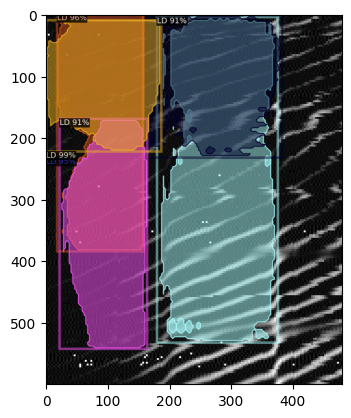

[ 0  3 62 74]


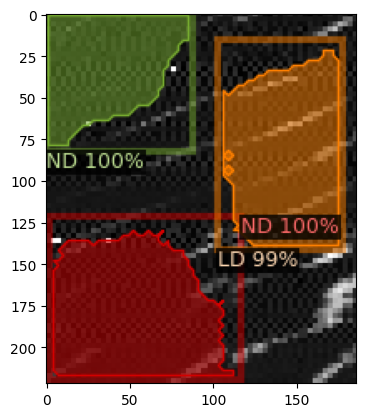

[  5   0  52 128]


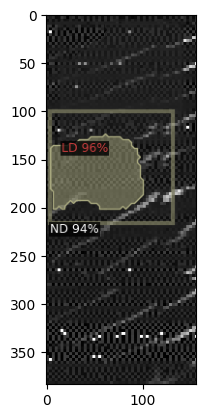

[  0   0 127  77]


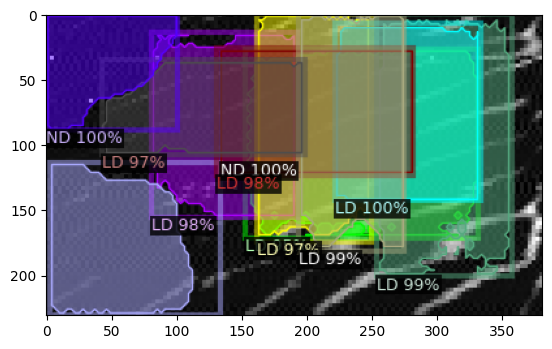

[ 60   1 125 177]


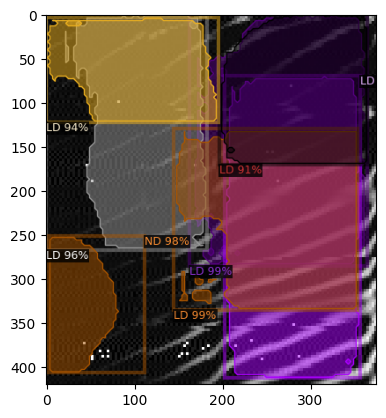

[  7  56  54 180]


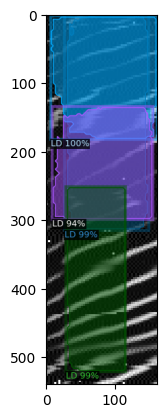

In [155]:
# img = cv2.rotate(img, cv2.ROTATE_180)
outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
csd_test_metadata = MetadataCatalog.get("csd_val")
v = Visualizer(img[:, :, ::-1],
                metadata=csd_test_metadata, 
                scale=3,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())
plt.show()

# Boxes
for box in outputs["instances"].pred_boxes.to('cpu'):
  
    box = box.type(torch.int).detach().numpy()
    print(box)
    # print("LB Voltages: ", np.unique(df['LB'].to_numpy())[box[0]:box[0]+box[2]])
    # print("RB Voltages: ", np.unique(df['RB'].to_numpy())[box[1]:box[1]+box[3]])
    new_img = Y[box[0]:box[0]+box[3], box[1]:box[1]+box[2]]
    new_img = new_img / new_img.max() # normalize the data to 0 - 1
    new_imgdata = 255 * new_img # Now scale by 255
    new_im = new_imgdata.astype(np.uint8)
    new_img = np.stack((new_im,new_im,new_im),axis=2)
    # new_img = cv2.rotate(new_img, cv2.ROTATE_180)
    outputs = predictor(new_img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    csd_test_metadata = MetadataCatalog.get("csd_val")
    v = Visualizer(new_img[:, :, ::-1],
                    metadata=csd_test_metadata, 
                    scale=3,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()



In [156]:
new_img = new_img.mean(axis=2)

In [166]:
# Initialize variables to keep track of the mask with the highest confidence
highest_confidence_mask = None
highest_confidence = -1  # Initialize to a value lower than any possible confidence score

# Iterate through all instance predictions and their associated confidence scores
instances = outputs["instances"].to("cpu")
for i in range(len(instances)):
    mask = instances.pred_masks[i]
    confidence_score = instances.scores[i]
    class_label = instances.pred_classes[i]
    print(class_label, confidence_score)
    
    # Check if the current mask has a higher confidence score than the previous highest
    if confidence_score > highest_confidence and class_label.item() == 1:
        highest_confidence = confidence_score
        highest_confidence_mask = mask

highest_confidence_mask = outputs["instances"].to("cpu").pred_masks[2]

tensor(1) tensor(0.9972)
tensor(1) tensor(0.9900)
tensor(1) tensor(0.9871)
tensor(1) tensor(0.9429)


In [167]:
print(highest_confidence_mask.shape)

torch.Size([180, 54])


(180, 54)
[-0.3181818181818182, -0.5882352941176471, -0.4, -0.5652173913043478, -0.4, -0.32432432432432434, -0.5789473684210527, -0.7, -0.5714285714285714, -0.6923076923076923, -0.2857142857142857, -0.3333333333333333, -0.2222222222222222, -0.34615384615384615, -0.26666666666666666, -0.21428571428571427, -0.35294117647058826, -0.42857142857142855, -0.4166666666666667, -0.4166666666666667, -0.21739130434782608, -0.4482758620689655, -0.4166666666666667, -0.45454545454545453, -0.3888888888888889, -0.5714285714285714]


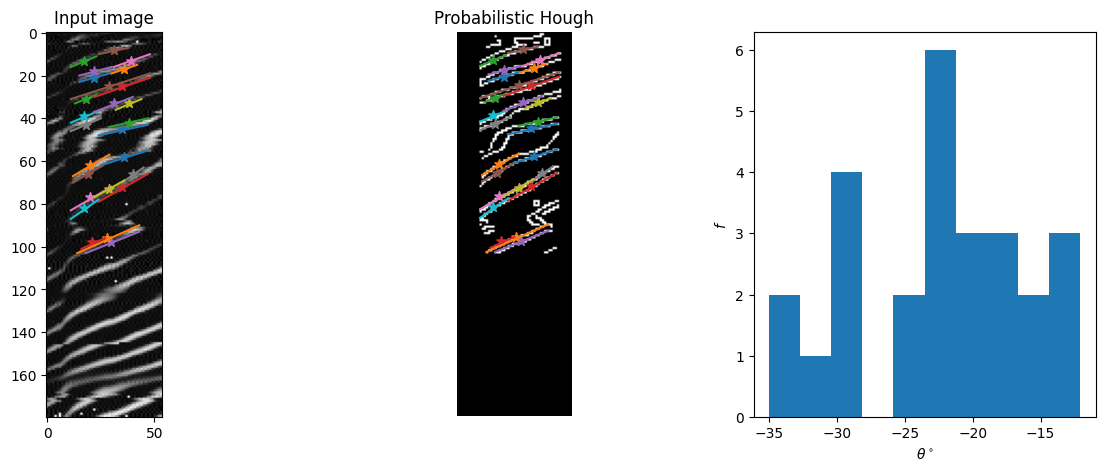

In [168]:
import skimage
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
print(new_img.shape)
edges = canny(new_img,sigma=1, low_threshold=0.1*np.iinfo(np.uint8).max, high_threshold=0.3 * np.iinfo(np.uint8).max, mask=highest_confidence_mask.numpy())
lines = probabilistic_hough_line(edges, threshold=0, line_length=10,
                                 line_gap=1)
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(new_img, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Masked Canny edges')

potential_points = {}
angles_data = []
slopes_data = []
for line in lines:
    p0, p1 = line
    m = (p1[1]-p0[1])/(p1[0]-p0[0])
    theta = np.arctan((p1[1]-p0[1])/(p1[0]-p0[0]))*(180/np.pi)
    angles_data.append(theta)
    slopes_data.append(m)
    midpoint = (np.array(p0) + np.array(p1))/2
    midpoint = midpoint.astype(int)
    current_at_midpoint = df['Idc'].to_numpy().reshape(len(X1), len(X2))[midpoint[0],midpoint[1]]
    potential_points[tuple(midpoint)] = current_at_midpoint

    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
    ax[1].scatter([midpoint[0]],[midpoint[1]], marker='*',s=50)
    ax[0].plot((p0[0], p1[0]), (p0[1], p1[1]))
    ax[0].scatter([midpoint[0]],[midpoint[1]], marker='*',s=50)
    
ax[1].set_xlim((0, new_img.shape[1]))
ax[1].set_ylim((new_img.shape[0], 0))
ax[1].set_title('Probabilistic Hough')
print(slopes_data)
ax[2].hist(angles_data, bins=2*int(np.sqrt(len(slopes_data))))
ax[2].set_xlabel(r"$\theta^\circ$")
ax[2].set_ylabel(r"$f$")
# ax[2].hist(angles_data)
# ax[0].set_axis_off()
ax[1].set_axis_off()

# plt.tight_layout()
# plt.show()
# # Classic straight-line Hough transform
# # Set a precision of 0.5 degree.
# # plt.imshow(edges,
# #             origin='lower',aspect='auto')
# # plt.show()
# tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
# h, theta, d = hough_line(new_img, theta=tested_angles)

# angle_step = 0.5 * np.diff(theta).mean()
# d_step = 0.5 * np.diff(d).mean()
# bounds = [np.rad2deg(theta[0] - angle_step),
#           np.rad2deg(theta[-1] + angle_step),
#           d[-1] + d_step, d[0] - d_step]

# plt.figure(dpi=300, figsize=(3,2))

# plt.imshow(new_img,origin='lower')

# # 
# # plt.title('Detected lines')

# lines_dict = {}
# for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
#     if np.tan(angle + np.pi/2) > 5 or np.abs(np.tan(angle + np.pi/2)) < 0.7:
#         continue
#     (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])

#     plt.axline((x0, y0), slope=np.tan(angle + np.pi/2),c='b')
#     def x_intercept(point, slope):
#         x_0, y_0 = point
#         x_intercept_value = x_0 - y_0 / slope
#         return x_intercept_value
# #     x_int_index = round(x_intercept([x0,y0],np.tan(angle + np.pi/2)))
# #     x_int = x[min_v_index + round(x_intercept([x0,y0],np.tan(angle + np.pi/2)))]
# #     slope =np.tan(angle + np.pi/2)

# #     P_x_int = [x_int_index, 0]
# #     P = [round(max_h_index/ slope + x_int_index), max_h_index]
# #     plt.scatter([x_int_index], [0])
# #     plt.scatter([round(max_h_index/ slope + x_int_index)], [max_h_index])
# #     true_slope = (1e-6*(y[P[1]] - y[P_x_int[1]] ))/ (1e-3*(x[min_v_index + P[0]] - x[min_v_index + P_x_int[0]]))

# #     lines_dict[x_int_index] = true_slope 

# # result, inverse_reciprocal_sums = cluster_x_intercepts(lines_dict)
# # print(result, inverse_reciprocal_sums)
# plt.xlabel("Pixel #")
# plt.ylabel("Pixel #")
# plt.show()
# # print(slopes)
# # binwidth = 0.01
# plt.hist(slopes, bins=np.arange(min(slopes), max(slopes) + binwidth, binwidth))
# plt.show()

In [160]:
print(potential_points)
max_key = np.array(max(potential_points, key=potential_points.get))
print("Key with the highest value:", max_key)

{(16, 31): 8.407952880859374e-12, (42, 23): 5.3440551757812505e-12, (19, 22): 7.146588134765625e-12, (15, 41): 1.899139404296875e-12, (17, 51): 1.6731524658203124e-11, (19, 28): 1.6122088623046873e-11, (41, 21): 1.9722821044921876e-11, (27, 10): 1.4377203369140624e-11, (35, 14): 1.805830078125e-11, (37, 45): 1.4303973388671876e-11, (35, 42): 1.4569415283203125e-11, (18, 10): 2.1542291259765623e-11, (42, 32): 2.01944580078125e-11, (41, 29): 4.429766845703125e-12, (33, 56): 2.2470135498046876e-11, (31, 36): 1.1755627441406247e-11, (45, 13): 1.32843017578125e-13, (14, 15): 4.309844970703125e-12, (17, 43): 1.679404296875e-11, (30, 18): 2.456939697265625e-12, (28, 27): 2.8884356689453127e-11, (13, 12): 2.6047705078125e-11, (42, 56): 2.125537109375e-11, (36, 23): 1.514443359375e-11}
Key with the highest value: [28 27]


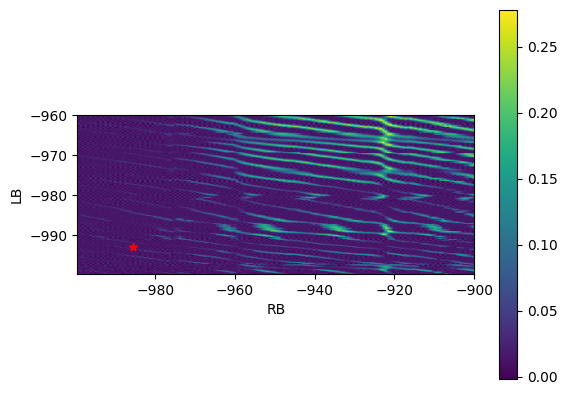

In [162]:
I = df['Idc'].to_numpy().reshape(len(X1), len(X2))/1e-9
plt.imshow(I,extent=[X1[0], X1[-1], X2[0], X2[-1]],origin='lower', vmin=I.min(), vmax=I.max())
plt.xlabel('RB')
plt.ylabel('LB')
plt.colorbar()

best_point = [X1[max_key[0]], X2[max_key[1]]]
plt.scatter(*best_point, marker='*', c='r')
plt.show()

In [ ]:
1